In [1]:
from zumi.zumi import Zumi
from zumi.util.screen import Screen
import time
from datetime import datetime
from zumi.util.vision import Vision
from zumi.util.camera import Camera 
from zumi.personality import Personality
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

zumi =    Zumi()
camera    = Camera()
screen    = Screen()
vision    = Vision()
personality = Personality(zumi, screen)

Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
Zumi battery level  34 %


In [2]:
zumi.get_battery_percent()

47

In [3]:
zumi.mpu.calibrate_MPU()

Creating new offset file...
.
.


In [4]:
log = {}
def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
        zumi.stop()
        time.sleep(0.01) 
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
        zumi.stop()
        time.sleep(0.01) 
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn, angle = 90):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(angle)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(2*angle)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle, times=3):
    zumi.reset_gyro() 
    for x in range(times):
        zumi.go_straight(speed, desired_angle)
    zumi.stop()

def object_detected(threshold=100):
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data() # Get center IR sensor value
    
    return front_right < threshold and front_left < threshold

def log_event(action):
    timestamp = datetime.now()
    log[action] = log.setdefault(action, [])
    log[action].append(timestamp)

def circle(turn, number_of_objects, threshold, speed=4):
    log_event("start "+ turn+ " circle")
    zumi.reset_gyro()
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, 0)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    for j in range(number_of_objects):
        for i in range(4):
            zumi.reset_gyro()
            if turn == 'left':
                zumi.signal_left_on()
                zumi.turn_left(90)
                zumi.signal_left_off()
                log_event('move_left')
            elif turn == 'right':
                zumi.signal_right_on()
                zumi.turn_right(90)
                zumi.signal_right_off()
                log_event('move_right')
            desired_angle = zumi.read_z_angle()
            desired_angle = turning_correction(desired_angle, 90)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.reset_gyro()
            while bottom_left > threshold or bottom_right > threshold:
                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
                zumi.go_straight(speed, desired_angle)
            zumi.stop()
    log_event("done "+ turn+ " circle")
    log_event('move_after_turning_left')

def find_the_finish_line():
    speed = 3
    threshold = 100
    zumi.reset_gyro()

    turned_left_angle = turn_to_check('left', 80)
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
    if bottom_left > threshold and bottom_right > threshold:
        print("line left")
        while (bottom_left > threshold and bottom_right > threshold):
            zumi.turn_right(5)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        zumi.reset_gyro()
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, 0)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        
        move_after_turning(speed, 0, 15)
        zumi.turn_right(25)
    else:
        print("no line left")
        turned_right_angle = turn_to_check('right', 80)        
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        while (bottom_left > threshold and bottom_right > threshold):
            zumi.turn_left(5)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        zumi.reset_gyro()
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, 0)
            if bottom_right > threshold and bottom_left > threshold:
                print("line found")
                zumi.stop()
                break
        
        move_after_turning(speed, 0, 15)
        
        zumi.turn_left(25)
    zumi.reset_gyro()
    
def find_line(angle_to_turn):
    zumi.reset_gyro()
    speed = 5
    threshold = 100
    # Move if sitll on line
    
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    # Move to find new line
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right > threshold and bottom_left > threshold:
            zumi.stop()
            break
    log_event("again_on_line")

    start_time = time.time()
    while True:
        if time.time() - start_time > 1:
            zumi.stop()
            print("time is out")
            break
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break

    log_event("out_of_line")
    if (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 0.3 :
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right < threshold and bottom_left < threshold:
                zumi.stop()
                break

        move_after_turning(speed, 0, 3)
        find_the_finish_line()
    elif (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 1:
        print("find_line_2")
        move_after_turning(speed, 0, 3)
        find_the_finish_line()


def dance_360(turn, times):
    if turn == 'left':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_left_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_left(angle_to_turn)
                angle_to_turn = 360 - zumi.read_z_angle()
            zumi.signal_left_off()
            zumi.stop()
        return angle_to_turn
    elif turn == 'right':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_right_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_right(angle_to_turn)
                angle_to_turn = 360 + zumi.read_z_angle()
            zumi.signal_right_off()
            zumi.stop()
        return angle_to_turn

def what_after_object(speed, number_of_objects, number_of_faces, threshold):
    number_of_turns = number_of_objects - number_of_faces
    camera.start_camera()
    for _ in range(5):
        frame = camera.capture()
        camera.show_image(frame)
        qr_code = vision.find_QR_code(frame)
        message = vision.get_QR_message(qr_code)
        if message != None:
            camera.close()
            screen.draw_text_center("QR Code Detected!")
            log_event("qr_code_command:"+ str(message))
            print("QR code detected!")
            qr_code_command(message, speed, number_of_turns , threshold)
            log_event("qr_code_command:"+ str(message) +"done")
            break
        gray_picture = vision.convert_to_gray(frame)
        faces= vision.find_face(gray_picture)
        if faces != None:
            camera.close()
            screen.draw_text_center("Face Detected!")
            log_event("face_detected")
            print("Face detected!")
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = str(timestamp)+".png"
            cv2.imwrite(filename, gray_picture)
            number_of_faces += 1
            log_event('face_count: ' + str(number_of_faces))
            break
        time.sleep(1)
    camera.close()
    return number_of_faces

def qr_code_command(message, speed, number_of_turns, threshold):
    print("QR code message: ", message)
    if message == "Left Circle":
        circle('left', number_of_turns, threshold)
    elif message == "Right Circle":
        circle('right', number_of_turns, threshold)
    elif message == "Turn Left":
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif message == "Turn Right":
        zumi.signal_right_on()
        zumi.turn_right(90)
        zumi.signal_right_off()
    elif message == "Stop":
        zumi.stop()
    elif message == "Zumi is happy today!":
        personality.happy()
    elif message == "Zumi is angry today!":
        personality.angry()
    elif message == "Zumi is celebrating today!":
        personality.celebrate()
    elif "360" in str(message):

        spin_message = message.split(" ")
        times = int(spin_message[0])
        turn = spin_message[3][:-1]
        emotion = spin_message[-1]

        print("turn", turn)
        angle_to_turn = dance_360(turn, times)*2

        if emotion == "happy":
            personality.happy()
        elif emotion == "angry":
            personality.angry()
        elif emotion == "celebrating":
            personality.celebrate()
        zumi.stop()
        
        print("Angle to turn: ", angle_to_turn)
        find_line(angle_to_turn)
    else:
        print("Invalid command")
        return "Invalid command"


def finish_with_180_turn():
    zumi.stop()
    log_event("finish")
    print("Reached end. Performing 180° turn.")
    screen.draw_text_center("Finisher box\nTurning 180°")
    zumi.turn_left(180)
    screen.draw_text_center("Done!")

def save_dict_to_csv(data_dict):
    # Generate file name with current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = "Zumi7337_output_" + current_time + ".csv"

    # Create empty list to store rows
    rows = []

    # Go through all actions and timestamps
    for action, timestamps in data_dict.items():
        for timestamp in timestamps:
            # Add row to list of rows
            rows.append({"timestamp": timestamp, "action": action})

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows)

    # Sort DataFrame by column timestamp
    df = df.sort_values(by='timestamp')

    # Calculate run time
    if 'start' in data_dict and 'stop' in data_dict:
        start_time = data_dict['start'][0]
        stop_time = data_dict['stop'][-1]
        runtime = stop_time - start_time
        # Append as a new row
        df = pd.concat([df, pd.DataFrame([{
            'timestamp': stop_time,
            'action': 'run_time: ' + str(runtime)
        }])], ignore_index=True)

    # Save DataFrame in CSV file
    df.to_csv(file_name, index=False)
    
def log_to_dataframe(log_dict):
    rows = []
    for action, timestamps in log_dict.items():
        for timestamp in timestamps:
            rows.append({"timestamp": timestamp, "action": action})
    df = pd.DataFrame(rows)
    df = df.sort_values(by="timestamp").reset_index(drop=True)
    return df

def extract_movement_and_path(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    movement_starts = {
        'start', 'continue_moving_after_object', 'starting_course',
        'move_after_turning_right', 'move_after_turning_left'
    }
    interrupts = {'object_detected', 'end_line'}
    DIRECTIONS = ['north', 'east', 'south', 'west']
    MOVE = {
        'north': (0, -1),
        'east': (1, 0),
        'south': (0, 1),
        'west': (-1, 0)
    }

    def update_direction(action, index):
        if action == 'move_after_turning_right':
            return (index + 1) % 4
        elif action == 'move_after_turning_left':
            return (index - 1) % 4
        return index

    GRID_SIZE = 600
    CENTER = GRID_SIZE // 2
    grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    x, y = CENTER, CENTER
    grid[y, x] = 1
    step = 2

    current_direction_index = 3  # Start facing west

    movements = []
    i = 0
    while i < len(df):
        action = df.loc[i, 'action']
        tentative_direction_index = update_direction(action, current_direction_index)

        if action in movement_starts:
            start_time = df.loc[i, 'timestamp']
            start_action = action
            pre_move_direction_index = current_direction_index
            facing_direction = DIRECTIONS[pre_move_direction_index]
            i += 1

            interrupt_time = None
            temp_direction_index = tentative_direction_index  # apply turns tentatively

            while i < len(df):
                current_action = df.loc[i, 'action']
                current_time = df.loc[i, 'timestamp']
                temp_direction_index = update_direction(current_action, temp_direction_index)

                if current_action in interrupts:
                    if current_action == 'end_line' and i + 1 < len(df) and df.loc[i + 1, 'action'] == 'end_line':
                        interrupt_time = df.loc[i + 1, 'timestamp']
                        i += 2
                    else:
                        interrupt_time = current_time
                        i += 1
                    break
                i += 1

            if interrupt_time:
                duration = (interrupt_time - start_time).total_seconds()

                if duration >= 1.0:
                    current_direction_index = temp_direction_index
                    facing_direction = DIRECTIONS[current_direction_index]
                else:
                    # Ignore turns for short movements
                    current_direction_index = pre_move_direction_index
                    facing_direction = DIRECTIONS[current_direction_index]

                dx, dy = MOVE[facing_direction]
                steps_to_take = int(round(duration))

                for _ in range(steps_to_take):
                    x += dx
                    y += dy
                    if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE:
                        grid[y, x] = step
                        step += 1

                movements.append({
                    'start_time': start_time,
                    'interrupt_time': interrupt_time,
                    'facing_direction': facing_direction,
                    'movement_duration_seconds': duration,
                    'start_action': start_action
                })

        elif action == 'start right circle':
            circle_start_time = df.loc[i, 'timestamp']
            circle_start_direction = DIRECTIONS[1]
            move_right_times = []
            i += 1

            while i < len(df):
                circle_action = df.loc[i, 'action']
                circle_time = df.loc[i, 'timestamp']

                if circle_action == 'move_right':
                    current_direction_index = update_direction(circle_action, current_direction_index)
                    move_right_times.append(circle_time)

                if circle_action == 'finish right circle':
                    circle_end_time = circle_time
                    duration = (circle_end_time - circle_start_time).total_seconds()

                    segment_durations = [
                        (move_right_times[j] - move_right_times[j - 1]).total_seconds()
                        for j in range(1, len(move_right_times))
                    ]
                    avg_side_duration = sum(segment_durations) / len(segment_durations) if segment_durations else None
                    side_count = len(move_right_times)
                    loop_count = side_count / 4 if side_count else 0
                    avg_loop_duration = duration / loop_count if loop_count else None

                    # Simulate path drawing
                    direction_sequence = ['north', 'east', 'south', 'west']
                    direction_index = direction_sequence.index(circle_start_direction)

                    for _ in range(side_count):
                        dir_str = direction_sequence[direction_index]
                        dx, dy = MOVE[dir_str]
                        steps_to_take = int(round(avg_side_duration)) if avg_side_duration else 0

                        for _ in range(steps_to_take):
                            x += dx
                            y += dy
                            if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE:
                                grid[y, x] = step
                                step += 1

                        direction_index = (direction_index + 1) % 4  # rotate clockwise

                    movements.append({
                        'start_time': circle_start_time,
                        'interrupt_time': circle_end_time,
                        'facing_direction': circle_start_direction,
                        'movement_duration_seconds': duration,
                        'start_action': 'circle_right',
                        'average_side_duration': avg_side_duration,
                        'side_count': side_count,
                        'loop_count': loop_count,
                        'average_loop_duration': avg_loop_duration
                    })

                    i += 1
                    break
                i += 1
        else:
            current_direction_index = tentative_direction_index  # allow directional update for non-movement-starts
            i += 1

    total_distance = np.count_nonzero(grid) - 1
    return pd.DataFrame(movements), grid, total_distance


def plot_path(grid, label):
    y_coords, x_coords = np.nonzero(grid)

    if len(x_coords) == 0 or len(y_coords) == 0:
        print("No movement found to plot.")
        return

    margin = 5
    xmin, xmax = max(0, x_coords.min() - margin), min(600, x_coords.max() + margin + 1)
    ymin, ymax = max(0, y_coords.min() - margin), min(600, y_coords.max() + margin + 1)

    cropped = np.array(grid[ymin:ymax, xmin:xmax])
    binary_grid = cropped > 0

    x_shift = 300
    y_shift = 300
    xmin_shifted = xmin - x_shift
    xmax_shifted = xmax - x_shift
    ymin_shifted = ymin - y_shift
    ymax_shifted = ymax - y_shift

    plt.figure(figsize=(8, 8))
    plt.imshow(
        binary_grid,
        cmap='Greys',
        origin='upper',
        extent=[xmin_shifted, xmax_shifted, ymax_shifted, ymin_shifted]
    )
    plt.title("Zumi Movement Path")
    plt.xlabel('X offset from start (seconds)')
    plt.ylabel('Y offset from start (seconds)')
    plt.gca().set_aspect('equal')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    plt.xticks(np.arange(xmin_shifted, xmax_shifted + 1, 1))
    plt.yticks(np.arange(ymin_shifted, ymax_shifted + 1, 1))
    plt.gca().set_facecolor('white')
    plt.tight_layout()

    filename = "Zumi7337_output_{}.png".format(label)
    plt.savefig(filename, dpi=300)
    print("Path image saved as:", filename)
    plt.close()


desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angle: 0.0
desired_angl

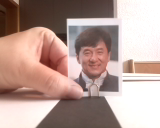

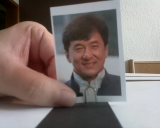

Closing PiCamera
Face detected!
Closing PiCamera
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001
desired_angle: 11.280000000000001

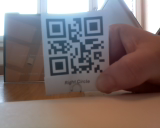

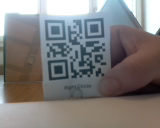

Closing PiCamera
QR code detected!
QR code message:  Right Circle
Closing PiCamera
desired_angle: 19.637
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -0.7560000000000002
desired_angle: -5.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desired_angle: -10.756
desire

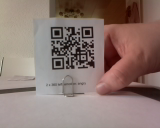

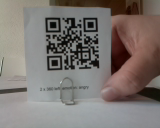

Closing PiCamera
QR code detected!
QR code message:  2 x 360 left, emotion: angry
turn left
Angle to turn:  -9.149999999999977
time is out
Closing PiCamera
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.972999999999999
desired_angle: -5.9729999999

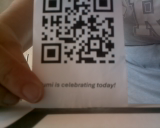

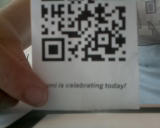

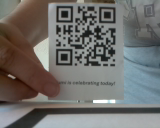

Closing PiCamera
QR code detected!
QR code message:  Zumi is celebrating today!
Closing PiCamera
Reached end. Performing 180° turn.
Path image saved as: Zumi7337_output_20250609_182557.png


In [5]:
log = {}
zumi.reset_gyro()
desired_angle = zumi.read_z_angle() 
number_of_objects = 0
number_of_faces = 0

log_event('start')
log_event('end_line')
time.sleep(1)
log_event('starting_course')

try:
    while True:
        # Set the threshold for the IR sensors and the speed
        threshold = 50 
        speed = 5

        if object_detected():
            zumi.stop()

            zumi.play_note(1, 500) # 1 is note type (1 - 60), 500 is duration in ms
            log_event('object_detected')
            screen.draw_text_center("Object detected") #Message that object was detected
            print("Waiting for object to be removed...")
            
            zumi.brake_lights_on()
            while object_detected():
                zumi.stop()
                time.sleep(0.1)
            zumi.brake_lights_off()
            
            number_of_objects += 1

            log_event('object_removed')
            log_event('object_count: ' + str(number_of_objects))
            print("Object removed. Resuming movement.")
            log_event('loking for qr_code of face')
            
            number_of_faces = what_after_object(speed, number_of_objects, number_of_faces, threshold)
            
            log_event('continue_moving_after_object')
        
        
        if any("Zumi is" in key for key in log):
            zumi.stop()
            log_event('stop')
            finish_with_180_turn()
            log_event('finish_with_180_turn')
            break
            

        # Read all IR sensor values
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        # Correction to line if one sensor is on the line and the other is off
        desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
        time.sleep(0.01) 
        print("desired_angle:", desired_angle)
        # Move forward with the corrected heading
        if bottom_left > threshold or bottom_right > threshold:
            zumi.go_straight(speed, desired_angle)
        else:
            log_event('end_line')
            if "done right circle" in log:
                if (datetime.now() - log['done right circle'][-1]).total_seconds() < 3:
                    zumi.stop()
                    time.sleep(3)
                    log['finish right circle'] = log.pop('done right circle')
            elif "done left circle" in log:
                if(datetime.now() - log['done left circle'][-1]).total_seconds() < 3:  
                    zumi.stop()
                    time.sleep(3) 
                    log['finish left circle'] = log.pop('done left circle')
            if (log['end_line'][-1] - log['end_line'][-2]).total_seconds() > 3:
                go_left = True
            
                log_event('check_left')
                # Turn to check if left is line
                turned_left_angle = turn_to_check('left')

                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_left_angle, 90)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            else:
                go_left = False
            if (bottom_left > threshold or bottom_right > threshold) and go_left:
                log_event('move_left')
                log_event('move_after_turning_left')
                move_after_turning(speed, desired_angle)
            else:
                
                log_event('check_right')
                # Turn to check if right is line
                turned_right_angle = turn_to_check('right') 
                
                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_right_angle, 180)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

                if bottom_left > threshold or bottom_right > threshold:
                    log_event('move_right')
                    log_event('move_after_turning_right')
                    move_after_turning(speed, desired_angle)
                else:
                    desired_angle = turn_to_check('left')
                    while (bottom_left < threshold or bottom_right < threshold):
                        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                        zumi.go_reverse(speed, desired_angle)

finally:
    zumi.stop()
    log_event('stop')
    manhattan_df = log_to_dataframe(log)
    movement_df, grid, total_distance = extract_movement_and_path(manhattan_df)
    log_event("total_manhattan_distance: {}".format(total_distance))
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_path(grid, timestamp)
    save_dict_to_csv(log)
    